# Similarity Matching

In [1]:
# Load Installation
%run setup.py

In [2]:
df_Invited = pd.read_csv(os.path.join(filepath,'factInvited.csv'))
df_Invited['Source'] = "Invited"

df_Proceedings = pd.read_csv(os.path.join(filepath,'factProceedings.csv'))
df_Proceedings['Source'] = "Proceedings"
# # Append data to one dataframe
df = pd.concat([df_Proceedings,df_Invited], sort=False, axis=0)

######################
# Data Preprocessing #
######################
df = df[df['Productivity'] != 0].reset_index(drop=True)
# df['log(Paper Count)'] = np.log(df['Paper Count'])
df['idx'] = df.index

def map_age_group(age_range):
    if age_range >=  20:
        return '>20'
    elif age_range >= 15:
        return '15-20'
    elif age_range >= 10:
        return '10-15'
    elif age_range >= 5:
        return '5-10'
    else:
        return '0-5'
    
df['Age Group'] = df['Age'].apply(map_age_group)

# Columns to normalize
columns_to_normalize = ['Paper Count', 'Productivity', 'Age']
# Normalize the selected columns
scaler = MinMaxScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

df.head(3)

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,column_equal,Paper Count,Max Paper Count,First year paper,ID,Age,Productivity,Conference (long),Main Topic,Source,idx,Age Group
0,Aaron Gage,2004,AAAI,Aaron,NaN,Gage,M,True,0.003762,8,1999,Aaron Gage_1,0.064516,0.018146,AAAI Conference on Artificial Intelligence,Artificial Intelligence,Proceedings,0,5-10
1,Abhi Shelat,2004,AAAI,Abhi,NaN,Shelat,M,True,0.003762,75,2002,Abhi Shelat_1,0.016129,0.045785,AAAI Conference on Artificial Intelligence,Artificial Intelligence,Proceedings,1,0-5
2,Adele E. Howe,2004,AAAI,Adele,E.,Howe,F,True,0.029467,91,1986,Adele E. Howe_1,0.274194,0.034818,AAAI Conference on Artificial Intelligence,Artificial Intelligence,Proceedings,2,15-20


# Similarity on gender

### Define function

In [17]:
def Nearest_Neighbor(df,k,q,n):
    df_F = df[df['gender'] == 'F'].reset_index(drop=True)
    df_M = df[df['gender'] == 'M']

    nbrs = NearestNeighbors(n_neighbors=k).fit(df_F[['Paper Count','Productivity','Age']])
    distances, indices = nbrs.kneighbors(df_M[['Paper Count','Productivity','Age']])
    
    # Find threshold
    threshold = np.quantile(distances.flatten(),q=q)
    mask = distances <= threshold
    filtered_indices = indices.copy().astype(float)
    filtered_indices[~mask] = np.nan
    
    # Initiliaze ratio list
    ratio_list = []
    
    for i in range(0,n):
        results = df_M.copy()
        results['Similar idx'] = [random.choice(row) for row in indices.tolist()] # select index
        results = results.dropna(subset=['Similar idx'])
        results = results.merge(right = df_F, left_on='Similar idx', right_index=True, how='left',suffixes=['_M','_F']) # merge info
        
        try:
            P_males_inv = results['Source_M'].value_counts(normalize=True).loc['Invited']
            P_females_inv = results['Source_F'].value_counts(normalize=True).loc['Invited']
            # ratio = np.divide(P_females_inv, P_females_inv+P_males_inv)
            ratio = np.divide(P_females_inv,P_males_inv)
            # ratio = np.divide(P_females_inv - P_males_inv, P_males_inv)
            ratio_list.append(ratio)
        except:
            ratio_list.append(np.nan)
            continue
    
    mean_ratio = np.nanmean(ratio_list)
    std_ratio = np.nanstd(ratio_list)
    
    return mean_ratio,std_ratio
    # return ratio_list

In [4]:
def KNN_distance(df, k, q, ax=None):
    df_F = df[df['gender'] == 'F'].reset_index(drop=True)
    df_M = df[df['gender'] == 'M']

    nbrs = NearestNeighbors(n_neighbors=k).fit(df_F[['Paper Count','Productivity','Age']])
    distances, indices = nbrs.kneighbors(df_M[['Paper Count','Productivity','Age']])
    
    # Find threshold
    threshold = np.quantile(distances.flatten(),q=q)
    # exlude distances = 0
    distances = distances[distances != 0]
    
    # Use the provided subplot (if any)
    if ax is not None:
        # Prepare data for log-log histogram
        bins = np.logspace(np.log10(min(distances.flatten())), np.log10(max(distances.flatten())), 20)
        hist,edges = np.histogram(distances.flatten(), bins=bins, density=True)
        x = (edges[1:]+edges[:-1])/2.
        
        xx,yy = zip(*[(i,j) for (i,j) in zip(x,hist) if j>0])

        ax.plot(xx, yy,marker='.')
        height = max(np.histogram(distances.flatten(),bins=100)[0])
        ax.vlines(threshold,0,height,colors="C1",linestyles="dashed",label='Threshold: '+str(q*100)+'%' ,linewidth=2.5)
        ax.set_title(str(df['Year'].unique()[0]) + ' and age group ' + str(df['Age Group'].unique()[0]) + ' for k = ' + str(k),fontsize=14)
        ax.set_xlabel('Distance')
        ax.set_ylabel('Probiability density')
        ax.set_xscale('log')
        ax.set_yscale('log')
        # ax.legend()
        plt.tight_layout()

## Line plots

### Distance

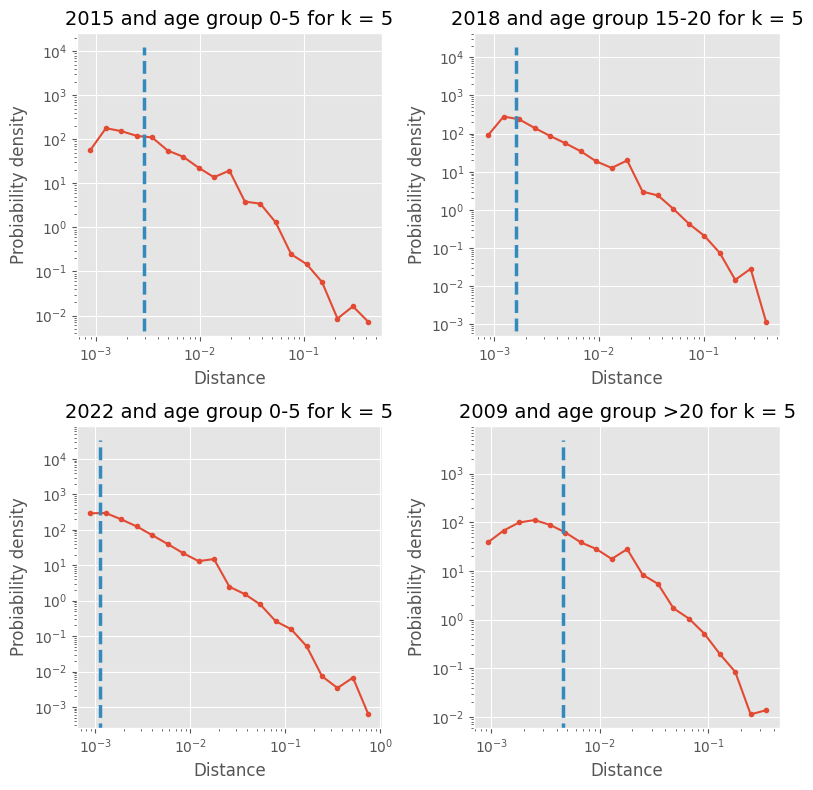

In [14]:
year_list = np.random.choice(range(2003,2023),size=4,replace=False)
fig, axs = plt.subplots(2, 2, figsize=(8, 8))


for id,year in enumerate(year_list):
    df_year = df[df['Year'] == year]
    ax = axs[id//2][id%2]
    KNN_distance(df_year,k=5, q=0.5, ax=ax) # write that k=5, q=0.5

### $\frac{F_{inv}}{F_{inv}+M_{inv}}$

100%|██████████| 20/20 [03:41<00:00, 11.07s/it]


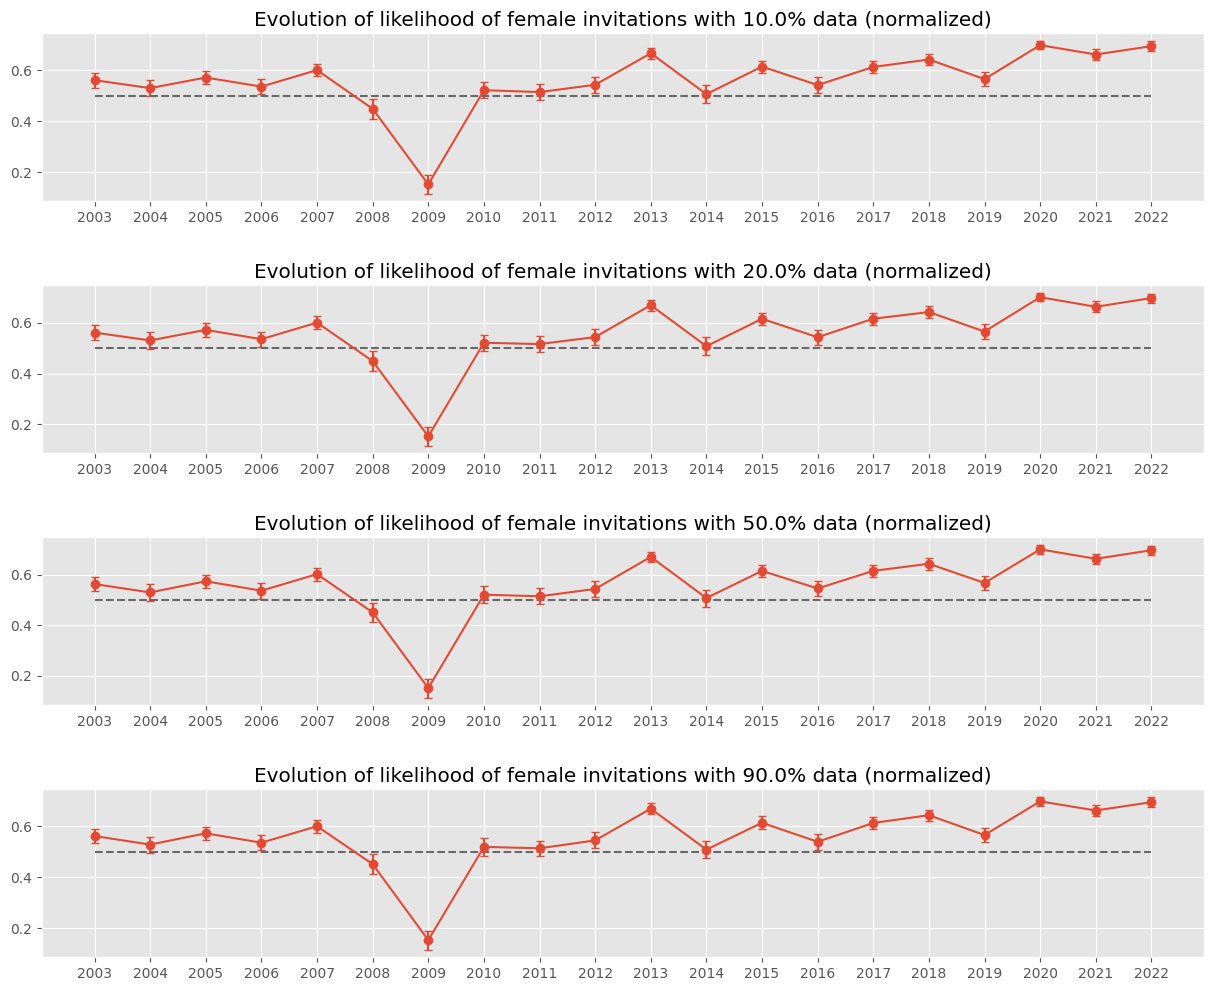

In [5]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
q_list = [0.1,0.2,0.5,0.9]

for n, q in enumerate(q_list):
    ax = plt.subplot(len(q_list), 1, n + 1)
    
    ratio_list = []
    std_list = []
    for year in tqdm(range(2003,2023)):
        try:
            df_year = df[df['Year'] == year]
            mean_ratio, std_ratio = Nearest_Neighbor(df_year,k=5, q=q, n=1000)
            ratio_list.append(mean_ratio)
            std_list.append(std_ratio)
        except: 
            ratio_list.append(np.NaN)
            std_list.append(np.NaN)
            continue
        
    ax.errorbar(range(2003,2023), ratio_list, yerr=std_list, fmt='o-', capsize=3,label="Adj. Ratio")
    ax.set_title('Evolution of likelihood of female invitations with ' + str(round(q*100,0)) + '% data (normalized)')
    ax.set_xticks(range(2003,2023,1))
    ax.hlines(0.5, 2003, 2022, linestyles='dashed',color='dimgrey')

plt.savefig(image_path+'line_sim_q_ALL_norm.pdf',bbox_inches='tight')

100%|██████████| 20/20 [05:08<00:00, 15.44s/it]


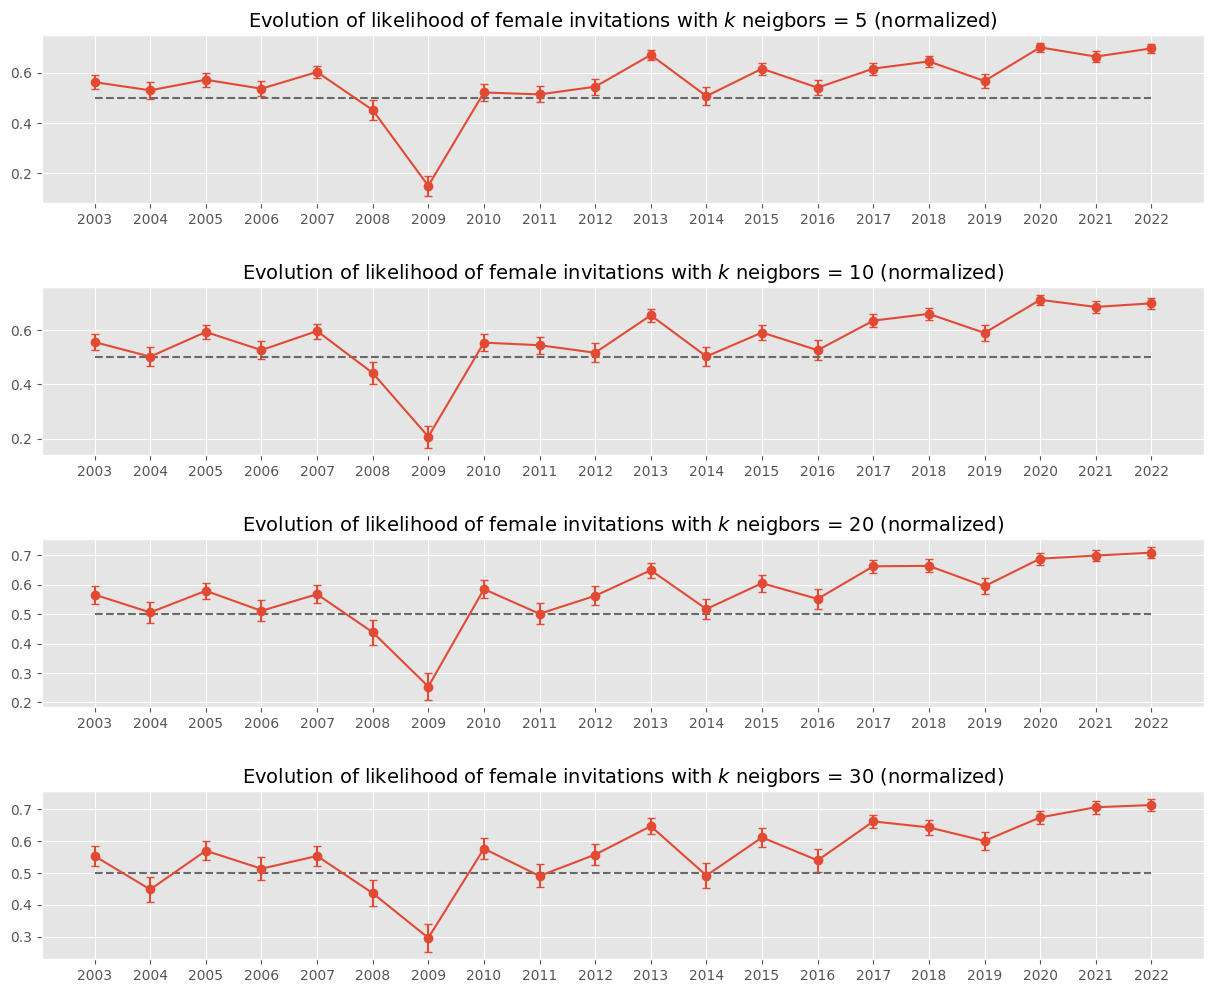

In [6]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
k_list = [5,10,20,30]

for n, k in enumerate(k_list):
    ax = plt.subplot(len(k_list), 1, n + 1)
    
    ratio_list = []
    std_list = []
    for year in tqdm(range(2003,2023)):
        try:
            df_year = df[df['Year'] == year]
            mean_ratio, std_ratio = Nearest_Neighbor(df_year,k=k, q=0.5, n=1000)
            ratio_list.append(mean_ratio)
            std_list.append(std_ratio)
        except: 
            ratio_list.append(np.NaN)
            std_list.append(np.NaN)
            continue
        
    ax.errorbar(range(2003,2023), ratio_list, yerr=std_list, fmt='o-', capsize=3,label="Adj. Ratio")
    ax.set_title('Evolution of likelihood of female invitations with $k$ neigbors = ' + str(k) + ' (normalized)',fontsize=14)
    ax.set_xticks(range(2003,2023,1),fontsize = 12)
    ax.hlines(0.5, 2003, 2022, linestyles='dashed',color='dimgrey')
    
plt.savefig(image_path+'line_sim_k_ALL_norm.pdf',bbox_inches='tight') 

100%|██████████| 20/20 [00:55<00:00,  2.79s/it]


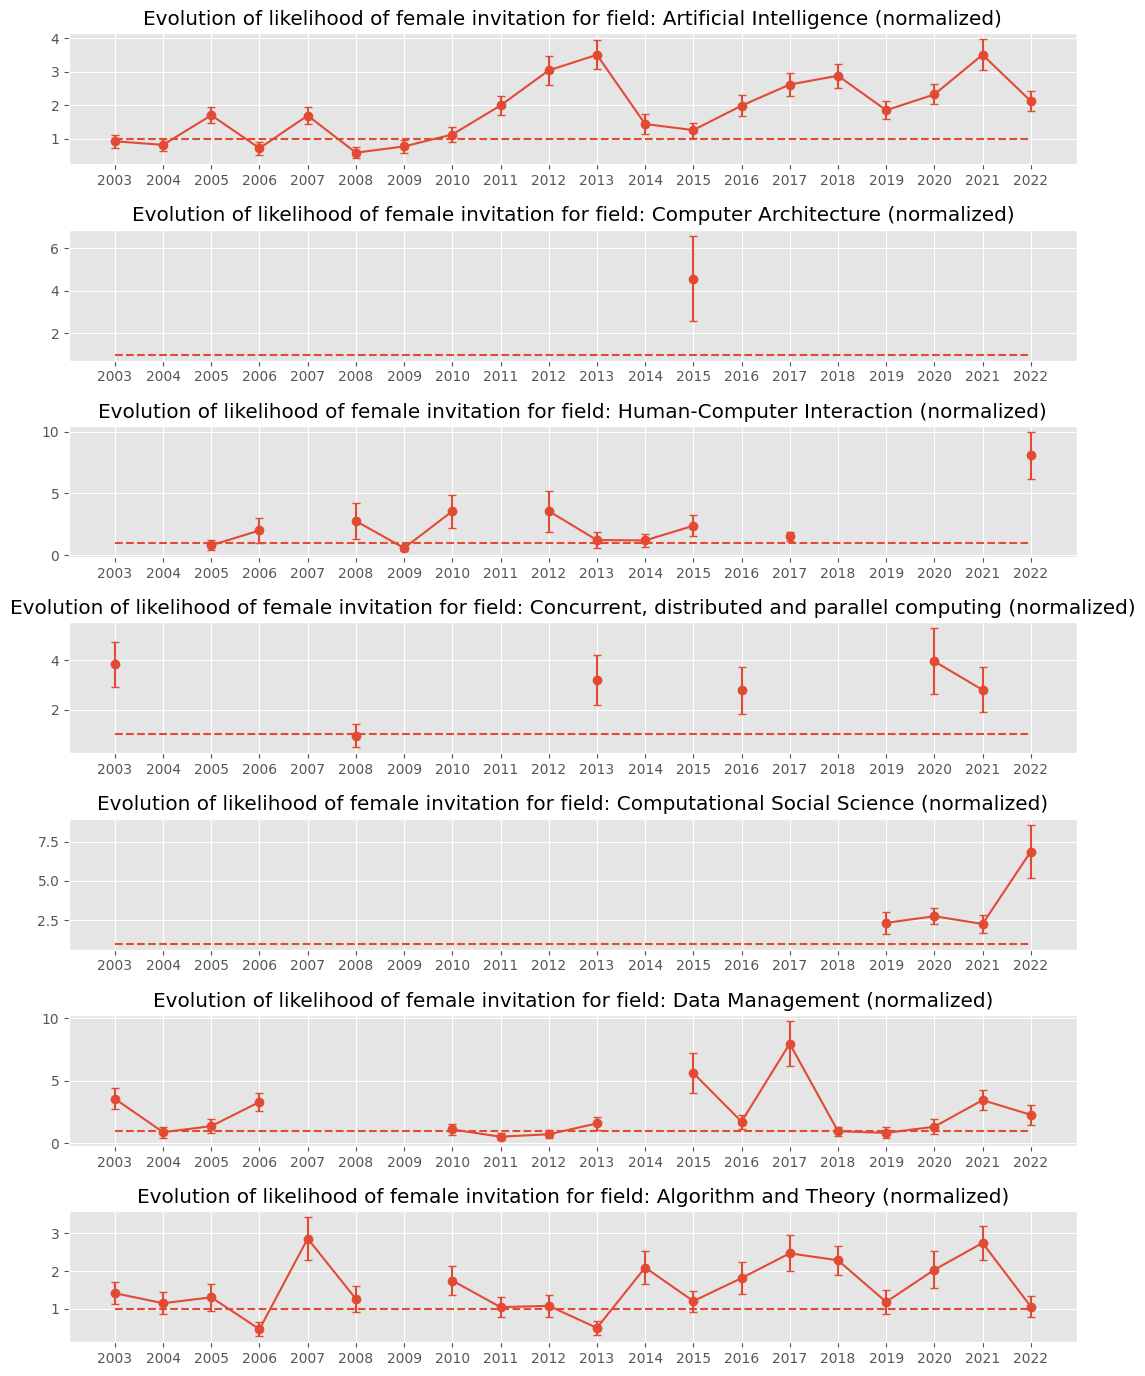

In [9]:
plt.figure(figsize=(13, 17))
plt.subplots_adjust(hspace=0.5)
field_list = list(df['Main Topic'].unique())

for n, f in enumerate(field_list):
    ax = plt.subplot(len(field_list), 1, n + 1)
    # ax.plot(df['Age'],'o',alpha=0.1)
    df_field = df[df['Main Topic'] == f]

    ratio_list = []
    std_list = []
    for year in tqdm(range(2003,2023)):
        try:
            df_year = df_field[df_field['Year'] == year]
            mean_ratio, std_ratio = Nearest_Neighbor(df_year,k=10, q=0.75, n=1000)
            ratio_list.append(mean_ratio)
            std_list.append(std_ratio)
        except: 
            ratio_list.append(np.NaN)
            std_list.append(np.NaN)
            continue
        
    ax.errorbar(range(2003,2023), ratio_list, yerr=std_list, fmt='o-', capsize=3,label="Adj. Ratio")
    ax.set_title('Evolution of likelihood of female invitation for field: ' + str(f) + ' (normalized)')
    ax.set_xticks(range(2003,2023,1))
    ax.hlines(0.5, 2003, 2022, linestyles='dashed',color='dimgrey')
    
plt.savefig(image_path+'line_sim_field_norm.pdf',bbox_inches='tight')     

### $\frac{F_{inv}}{M_{inv}}$

100%|██████████| 20/20 [03:49<00:00, 11.46s/it]


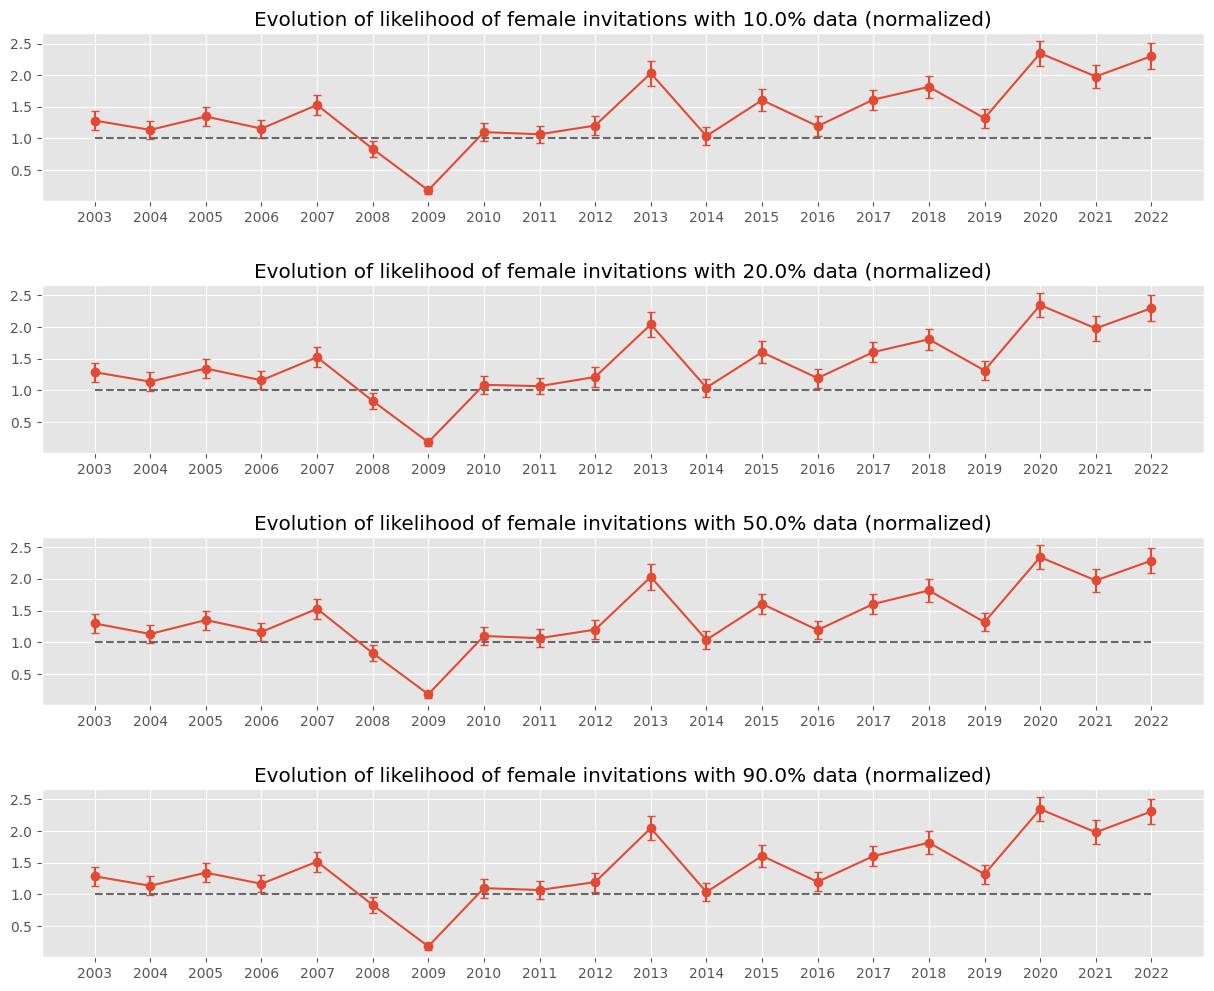

In [10]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
q_list = [0.1,0.2,0.5,0.9]

for n, q in enumerate(q_list):
    ax = plt.subplot(len(q_list), 1, n + 1)
    
    ratio_list = []
    std_list = []
    for year in tqdm(range(2003,2023)):
        try:
            df_year = df[df['Year'] == year]
            mean_ratio, std_ratio = Nearest_Neighbor(df_year,k=5, q=q, n=1000)
            ratio_list.append(mean_ratio)
            std_list.append(std_ratio)
        except: 
            ratio_list.append(np.NaN)
            std_list.append(np.NaN)
            continue
        
    ax.errorbar(range(2003,2023), ratio_list, yerr=std_list, fmt='o-', capsize=3,label="Adj. Ratio")
    ax.set_title('Evolution of likelihood of female invitations with ' + str(round(q*100,0)) + '% data (normalized)')
    ax.set_xticks(range(2003,2023,1))
    ax.hlines(1, 2003, 2022, linestyles='dashed',color='dimgrey')

plt.savefig(image_path+'line_sim_q_ALL2_norm.pdf',bbox_inches='tight')

100%|██████████| 20/20 [05:16<00:00, 15.84s/it]


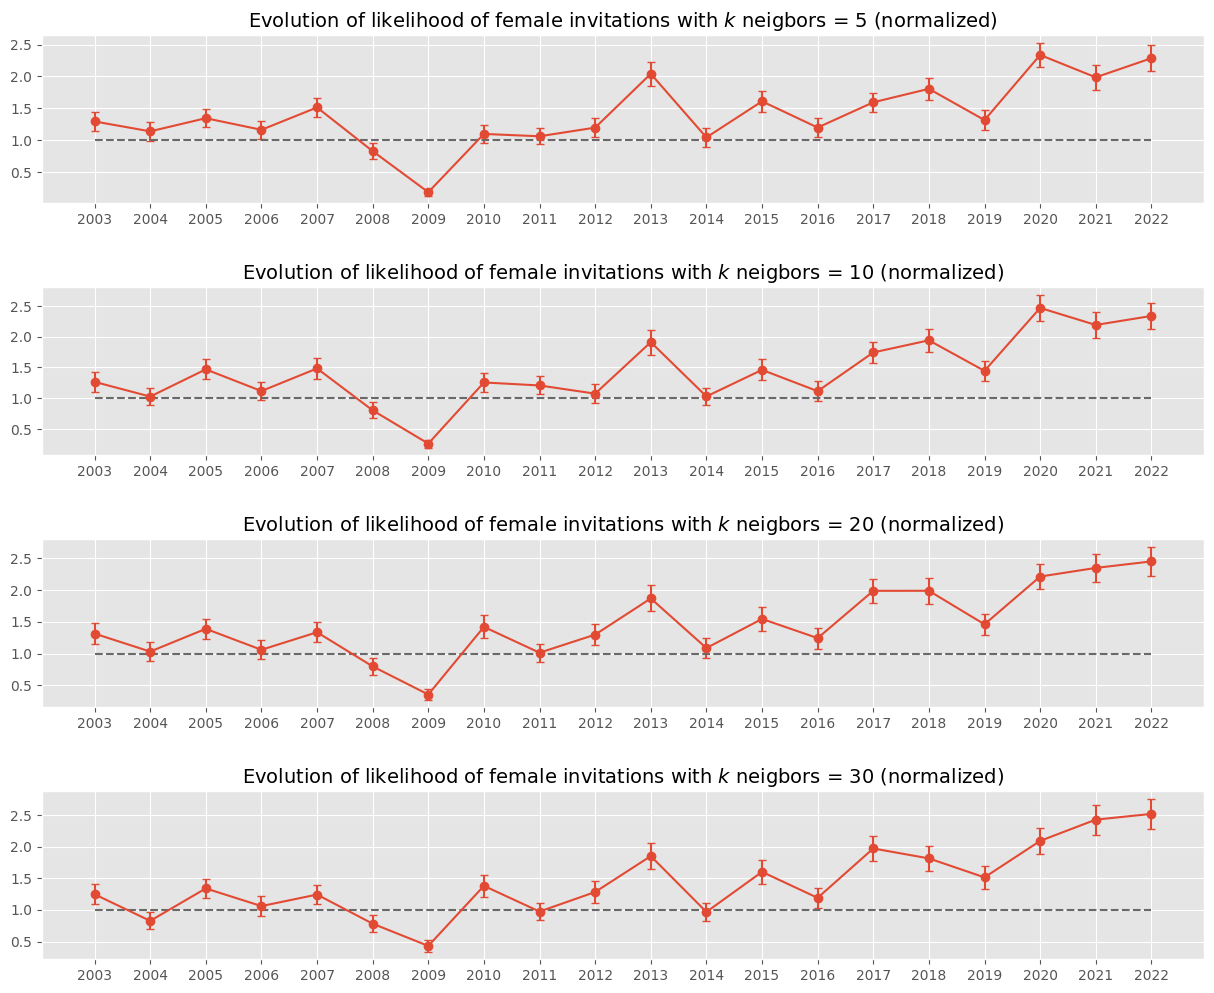

In [11]:
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
k_list = [5,10,20,30]

for n, k in enumerate(k_list):
    ax = plt.subplot(len(k_list), 1, n + 1)
    
    ratio_list = []
    std_list = []
    for year in tqdm(range(2003,2023)):
        try:
            df_year = df[df['Year'] == year]
            mean_ratio, std_ratio = Nearest_Neighbor(df_year,k=k, q=0.5, n=1000)
            ratio_list.append(mean_ratio)
            std_list.append(std_ratio)
        except: 
            ratio_list.append(np.NaN)
            std_list.append(np.NaN)
            continue
        
    ax.errorbar(range(2003,2023), ratio_list, yerr=std_list, fmt='o-', capsize=3,label="Adj. Ratio")
    ax.set_title('Evolution of likelihood of female invitations with $k$ neigbors = ' + str(k) + ' (normalized)',fontsize=14)
    ax.set_xticks(range(2003,2023,1),fontsize = 12)
    ax.hlines(1, 2003, 2022, linestyles='dashed',color='dimgrey')
    
plt.savefig(image_path+'line_sim_k_ALL2_norm.pdf',bbox_inches='tight') 

100%|██████████| 20/20 [00:00<00:00, 57.72it/s]


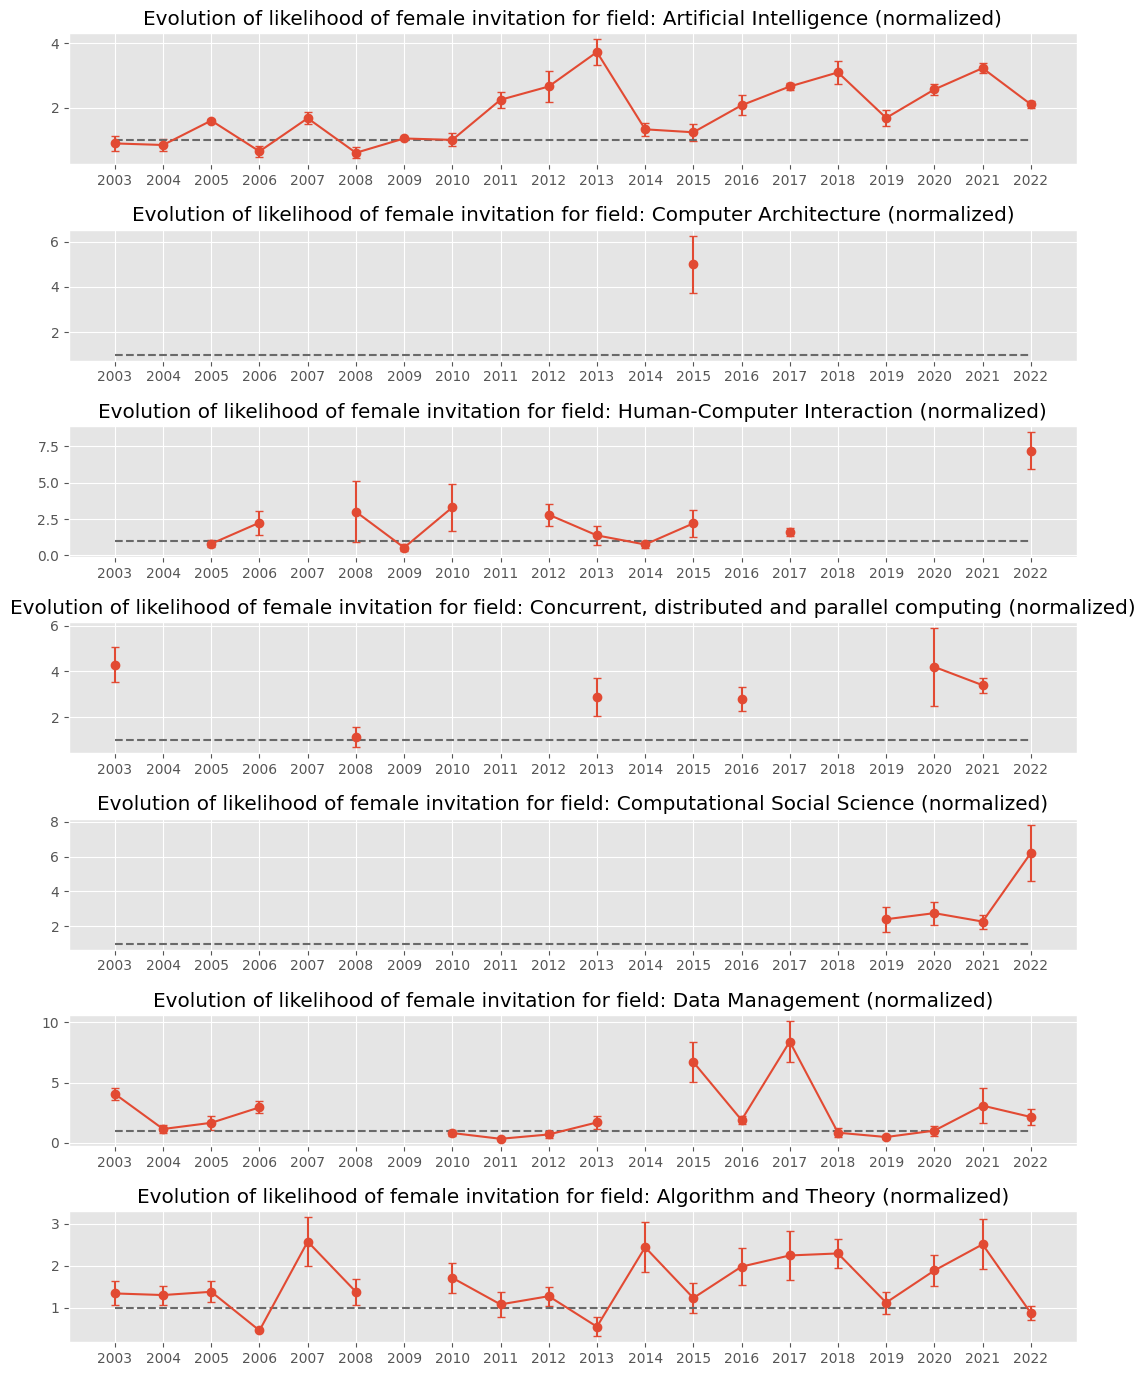

In [22]:
plt.figure(figsize=(13, 17))
plt.subplots_adjust(hspace=0.5)
field_list = list(df['Main Topic'].unique())

for n, f in enumerate(field_list):
    ax = plt.subplot(len(field_list), 1, n + 1)
    # ax.plot(df['Age'],'o',alpha=0.1)
    df_field = df[df['Main Topic'] == f]

    ratio_list = []
    std_list = []
    for year in tqdm(range(2003,2023)):
        try:
            df_year = df_field[df_field['Year'] == year]
            mean_ratio, std_ratio = Nearest_Neighbor(df_year,k=10, q=0.75, n=5)
            ratio_list.append(mean_ratio)
            std_list.append(std_ratio)
        except: 
            ratio_list.append(np.NaN)
            std_list.append(np.NaN)
            continue
        
    ax.errorbar(range(2003,2023), ratio_list, yerr=std_list, fmt='o-', capsize=3,label="Adj. Ratio")
    ax.set_title('Evolution of likelihood of female invitation for field: ' + str(f) + ' (normalized)')
    ax.set_xticks(range(2003,2023,1))
    ax.hlines(1, 2003, 2022, linestyles='dashed',color='dimgrey')

plt.savefig(image_path+'line_sim_field2_norm.pdf',bbox_inches='tight')     

## Heatmap 3D

### Distance

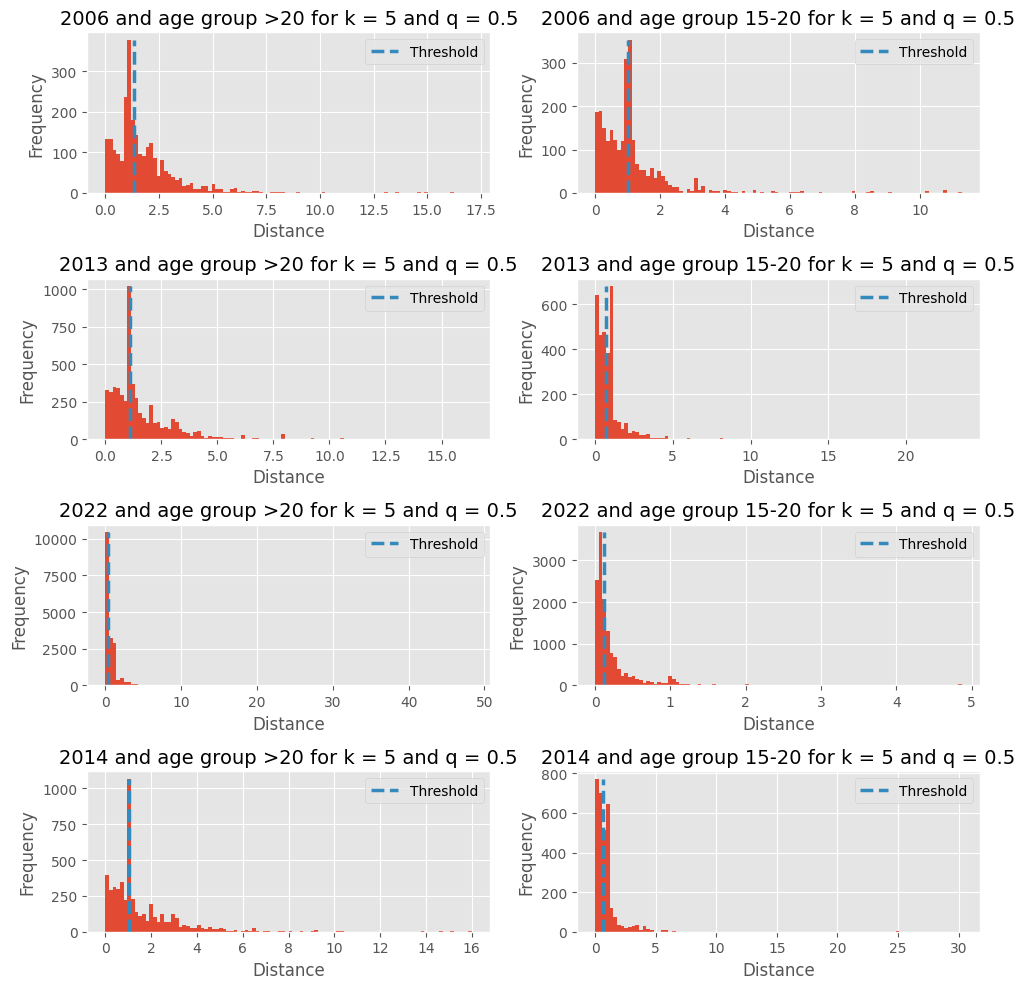

In [17]:
year_list = np.random.choice(range(2003,2023),size=4,replace=False)
age_list = np.random.choice(df['Age Group'].unique(),2,replace=False)
fig, axs = plt.subplots(4, 2, figsize=(10, 10))


for id_x, year in enumerate(year_list):
    for id_y, age in enumerate(age_list):
        df_filtered = df[(df['Age Group'] == age) & (df['Year'] == year)]
        ax = axs[id_x][id_y]
        KNN_distance(df_filtered,k=5, q=0.5, ax=ax) # write that k=5, q=0.5

### $\frac{F_{inv}}{F_{inv}+M_{inv}}$

In [12]:
ratio_list = []
for year in tqdm(range(2003,2023)):
    for age in df['Age Group'].unique(): 
        df_filtered = df[(df['Age Group'] == age) & (df['Year'] == year)]
        
        ratio_mean, _ = Nearest_Neighbor(df_filtered, k=10, q=0.5, n=1000)
        ratio_list.append(ratio_mean)
    
ratio_list = np.array(ratio_list).reshape(20,5)
# ratio_list

 30%|███       | 6/20 [01:27<03:23, 14.53s/it]


KeyboardInterrupt: 

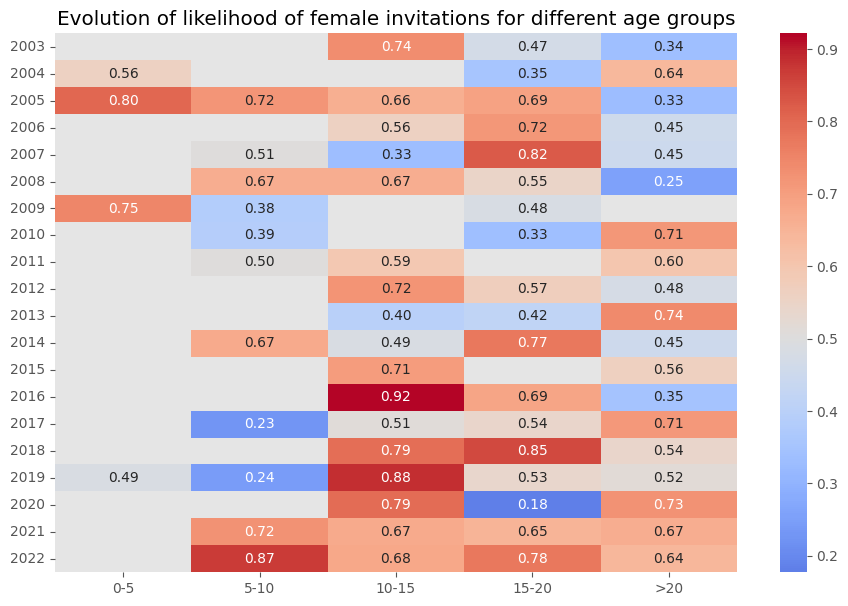

In [11]:
df_pivot = pd.DataFrame(ratio_list, columns=df['Age Group'].unique(), index=range(2003,2023))
age_group_order = ['0-5', '5-10', '10-15', '15-20', '>20']
df_pivot = df_pivot.reindex(columns=age_group_order)

# Plot
plt.figure(figsize=(11, 7))
sns.heatmap(df_pivot, cmap='coolwarm', annot=True, fmt='.2f', center = 0.5)
plt.title('Evolution of likelihood of female invitations for different age groups')
plt.show()

### $\frac{F_{inv}}{M_{inv}}$

In [19]:
ratio_list = []
for year in tqdm(range(2003,2023)):
    for age in df['Age Group'].unique(): 
        df_filtered = df[(df['Age Group'] == age) & (df['Year'] == year)]
        
        ratio_mean, _ = Nearest_Neighbor(df_filtered, k=10, q=0.5, n=1000)
        ratio_list.append(ratio_mean)
    
ratio_list = np.array(ratio_list).reshape(20,5)
# ratio_list

100%|██████████| 20/20 [05:50<00:00, 17.54s/it]


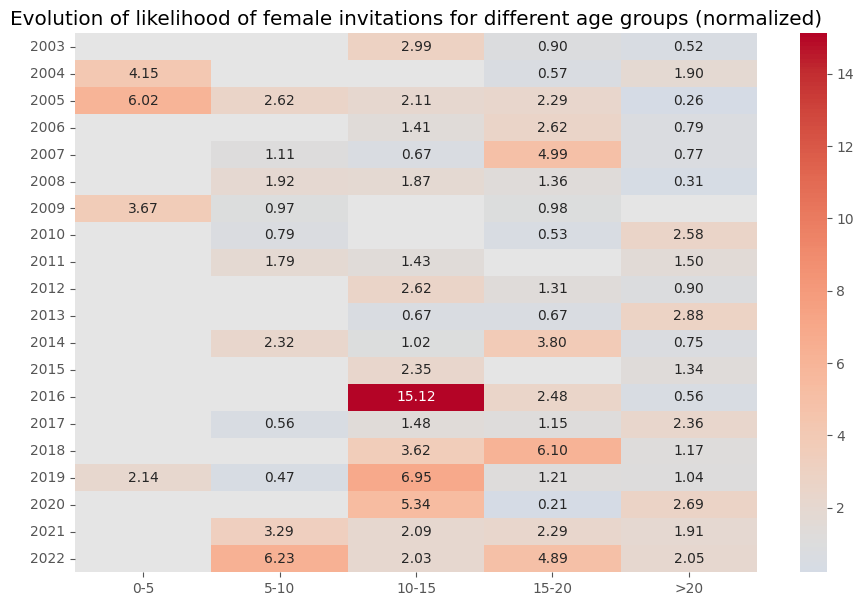

In [20]:
df_pivot = pd.DataFrame(ratio_list, columns=df['Age Group'].unique(), index=range(2003,2023))
age_group_order = ['0-5', '5-10', '10-15', '15-20', '>20']
df_pivot = df_pivot.reindex(columns=age_group_order)

# Plot
plt.figure(figsize=(11, 7))
sns.heatmap(df_pivot, cmap='coolwarm', annot=True, fmt='.2f', center = 1)
plt.title('Evolution of likelihood of female invitations for different age groups (normalized)')
plt.savefig(image_path+'heatmap2_norm.pdf',bbox_inches='tight')   
plt.show()

# Similarity on source

### All females and males

### $\frac{F_{inv}}{F_{inv}+M_{inv}}$

In [5]:
def knn_on_source(df,k,q):
    # Define empty lists and dataframes
    df2 = pd.DataFrame(columns=['True speaker', 'Potential speaker','Control','Year'])
    total_list = []


    for year in tqdm(range(2003,2023)):
        df_all = df[df['Year'] == year].reset_index(drop=True)
        df_inv = df_all[df_all['Source'] == 'Invited']

        ################################################################################
        # Use k-nearest neigbor
        ################################################################################
        nbrs = NearestNeighbors(n_neighbors=k).fit(df_all[['Paper Count','Productivity','Age']])
        distances, indices = nbrs.kneighbors(df_inv[['Paper Count','Productivity','Age']])
        
        
        ################################################################################
        # Clean up indices
        ################################################################################
        # Find threshold and replace distances above threshold with NaN
        threshold = np.quantile(distances.flatten(),q=q)
        mask = distances <= threshold
        filtered_indices = indices.copy().astype(float)
        filtered_indices[~mask] = np.nan

        # Remove yourself from the index list
        for i, indices in enumerate(filtered_indices):
            for j, idx in enumerate(indices):
                if pd.notnull(idx):
                    if df_inv.iloc[i]['idx'] == df_all.iloc[int(idx)]['idx']:
                        filtered_indices[i][j] = np.nan
                    
                    
        ################################################################################
        # Find the ratio of females of the k-nearest invited neighbors
        ################################################################################
        mean_list = []
        for i in range(0,len(filtered_indices)):
            try:
                # Takes the indices of the k-nearest neighbors and removes the NaN values
                new_list = filtered_indices[i][~np.isnan(filtered_indices[i])]
                # Finds the ratio of females of the k-nearest invited neighbors
                mean = df_all.loc[new_list,'gender'].value_counts(normalize=True)['F']
                mean_list.append(mean)
            except:
                mean_list.append(np.nan)
                continue
            
        # Take the mean of the all the ratios for the year
        total_list.append(np.nanmean(mean_list))
        
        ################################################################################
        # Find the relationship between the true speaker and the potential speaker
        ################################################################################
        list_inner1 = [] # list of the invited speakser
        list_inner2 = [] # list of the k-nearest neighbors

        for i, indices in enumerate(filtered_indices):
            for j,idx in enumerate(indices):
                list_inner1.append(df_inv.iloc[int(i)]['gender'])
                if pd.notnull(idx):
                    list_inner2.append(df_all.iloc[int(idx)]['gender'])
                else:
                    list_inner2.append(np.nan)

        combined_data = list(zip(list_inner1, list_inner2))
        df1 = pd.DataFrame(combined_data, columns=['True speaker', 'Potential speaker'])
        # drop rows with NaN values
        df1 = df1.dropna()

        conditions = [
            (df1['True speaker'] == 'F') & (df1['Potential speaker'] == 'F'),
            (df1['True speaker'] == 'F') & (df1['Potential speaker'] == 'M'),
            (df1['True speaker'] == 'M') & (df1['Potential speaker'] == 'F'),
            (df1['True speaker'] == 'M') & (df1['Potential speaker'] == 'M')
        ]
        values = ['F-F', 'F-M', 'M-F', 'M-M']

        # Create the new column based on the conditions
        df1['Control'] = np.select(conditions, values, default='Unknown')
        df1['Year'] = year
        df2 = pd.concat([df2,df1],axis=0)
    return df2, total_list

In [6]:
df2, total_list = knn_on_source(df,k=10,q=1)

100%|██████████| 20/20 [00:03<00:00,  5.80it/s]


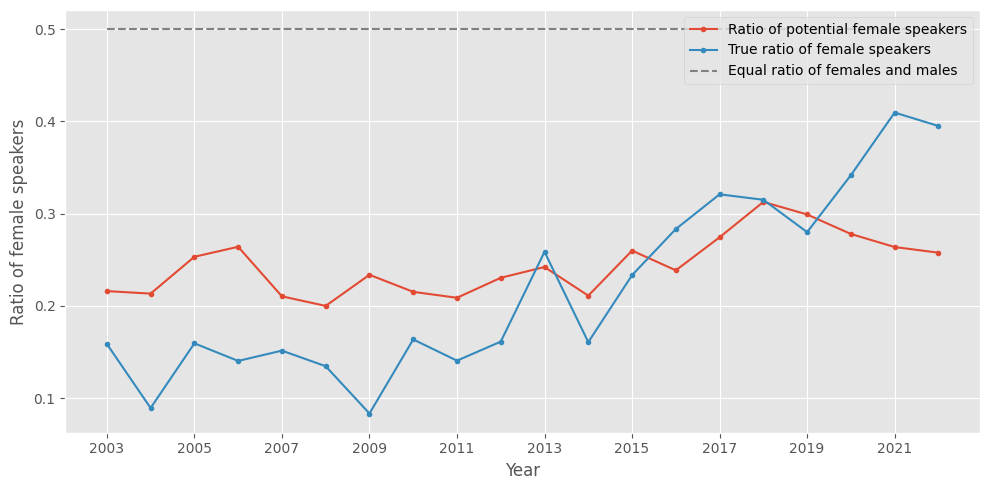

In [7]:
### Plot the result  
fig = plt.figure(figsize=(10,5))
plt.plot(range(2003,2023),total_list,marker='.',label='Ratio of potential female speakers')
# Plot the true ratio
True_list = df_Invited.groupby('Year')['gender'].value_counts(normalize=True).unstack()['F'].values
plt.plot(range(2003,2023),True_list,marker='.',label='True ratio of female speakers')

plt.xticks(range(2003,2023,2))
plt.xlabel('Year')
plt.ylabel('Ratio of female speakers')
plt.hlines(0.5,2003,2022,linestyles='dashed',colors='grey', label='Equal ratio of females and males')
plt.legend()
plt.tight_layout()
# plt.savefig(image_path+'image1.pdf')
plt.show()


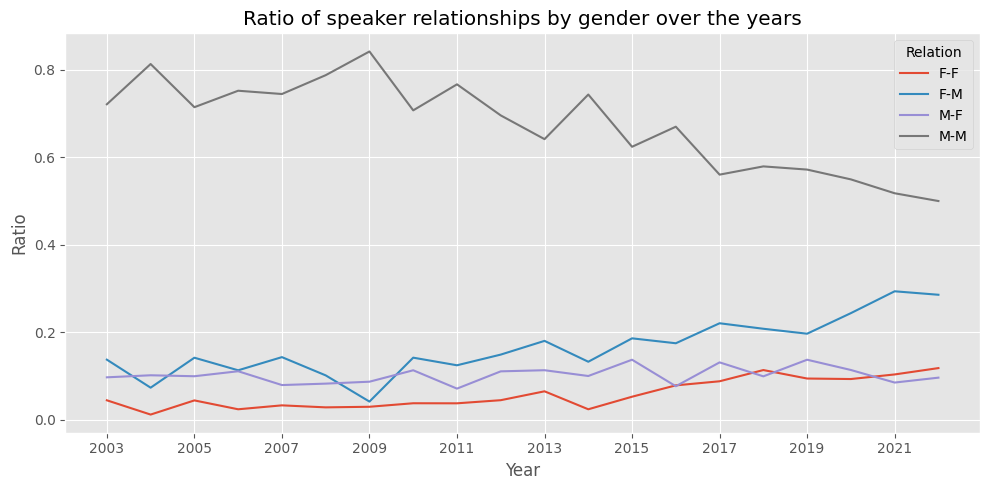

In [8]:
# Check the distribution of relationsshipts between females and male neighbors
df2.groupby('Year')['Control'].value_counts(normalize=True).unstack().plot(kind='line',figsize=(10,5))
plt.xticks(range(2003,2023,2))
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.title("Ratio of speaker relationships by gender over the years")
legend = plt.legend()
legend.set_title('Relation')
plt.tight_layout()

In [11]:
df3 = df2.groupby('Year')['Control'].value_counts(normalize=True).unstack()[['M-F','M-M']].reset_index()
df3['relationship ratio'] = np.divide(df3['M-M'],df3['M-F'])

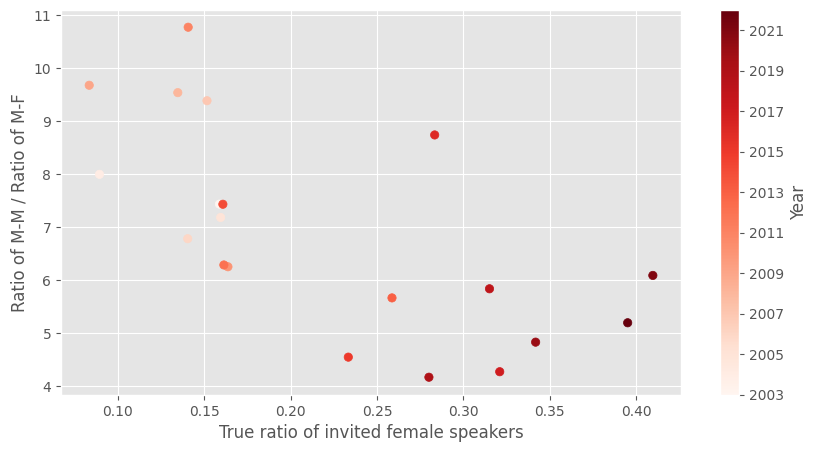

In [12]:
plt.figure(figsize=(10,5))
plt.scatter(True_list,df3['relationship ratio'],c=df3['Year'],cmap='Reds')
plt.xlabel('True ratio of invited female speakers')
plt.ylabel('Ratio of M-M / Ratio of M-F')
cbar = plt.colorbar(ticks=range(2003,2023,2))
cbar.set_label('Year')
    
plt.show()

### Plots with different number of neighbors and thresholds

100%|██████████| 20/20 [00:03<00:00,  6.19it/s]


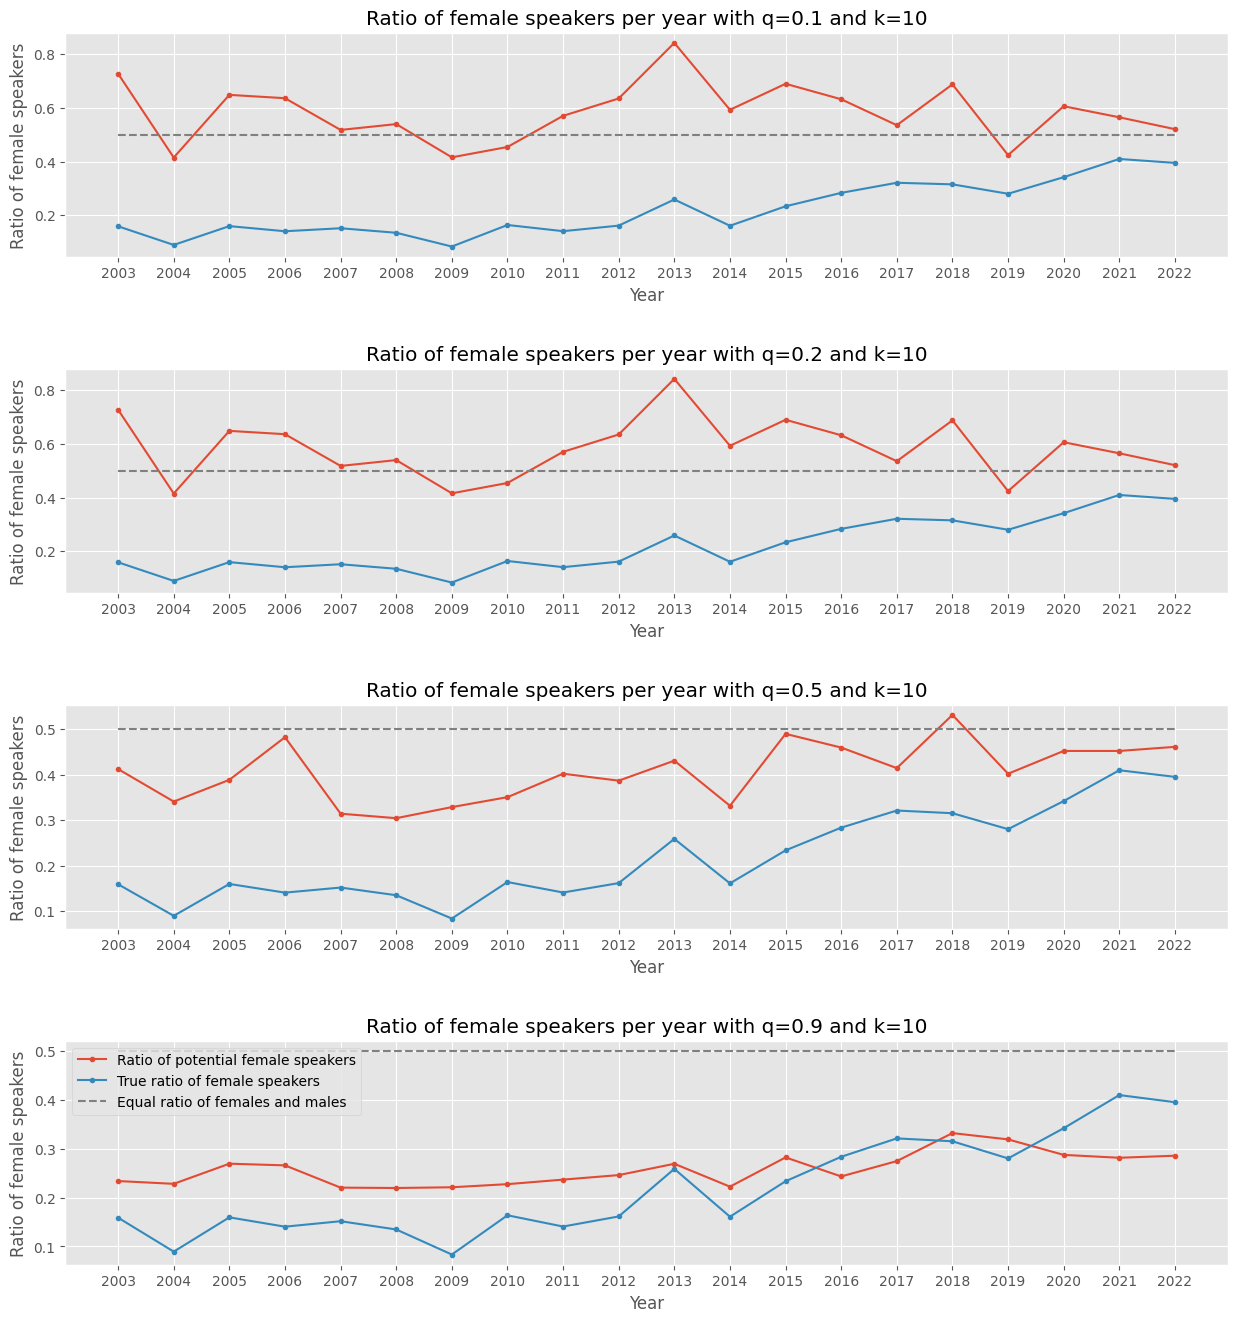

In [252]:
plt.figure(figsize=(15, 16))
plt.subplots_adjust(hspace=0.5)
q_list = [0.1,0.2,0.5,0.9]

for n, q in enumerate(q_list):
    ax = plt.subplot(len(q_list), 1, n + 1)
    
    _, total_list = knn_on_source(df,k=10,q=q)
        
    ax.plot(range(2003,2023),total_list,marker='.',label='Ratio of potential female speakers')
    # Plot the true ratio
    True_list = df_Invited.groupby('Year')['gender'].value_counts(normalize=True).unstack()['F'].values
    ax.plot(range(2003,2023),True_list,marker='.',label='True ratio of female speakers')

    ax.set_xticks(range(2003,2023,1))
    ax.set_xlabel('Year')
    ax.set_ylabel('Ratio of female speakers')
    ax.set_title('Ratio of female speakers per year with q='+str(q)+' and k=' + str(10))
    ax.hlines(0.5,2003,2022,linestyles='dashed',colors='grey', label='Equal ratio of females and males')

plt.legend()    
plt.show()

100%|██████████| 20/20 [00:05<00:00,  3.75it/s]


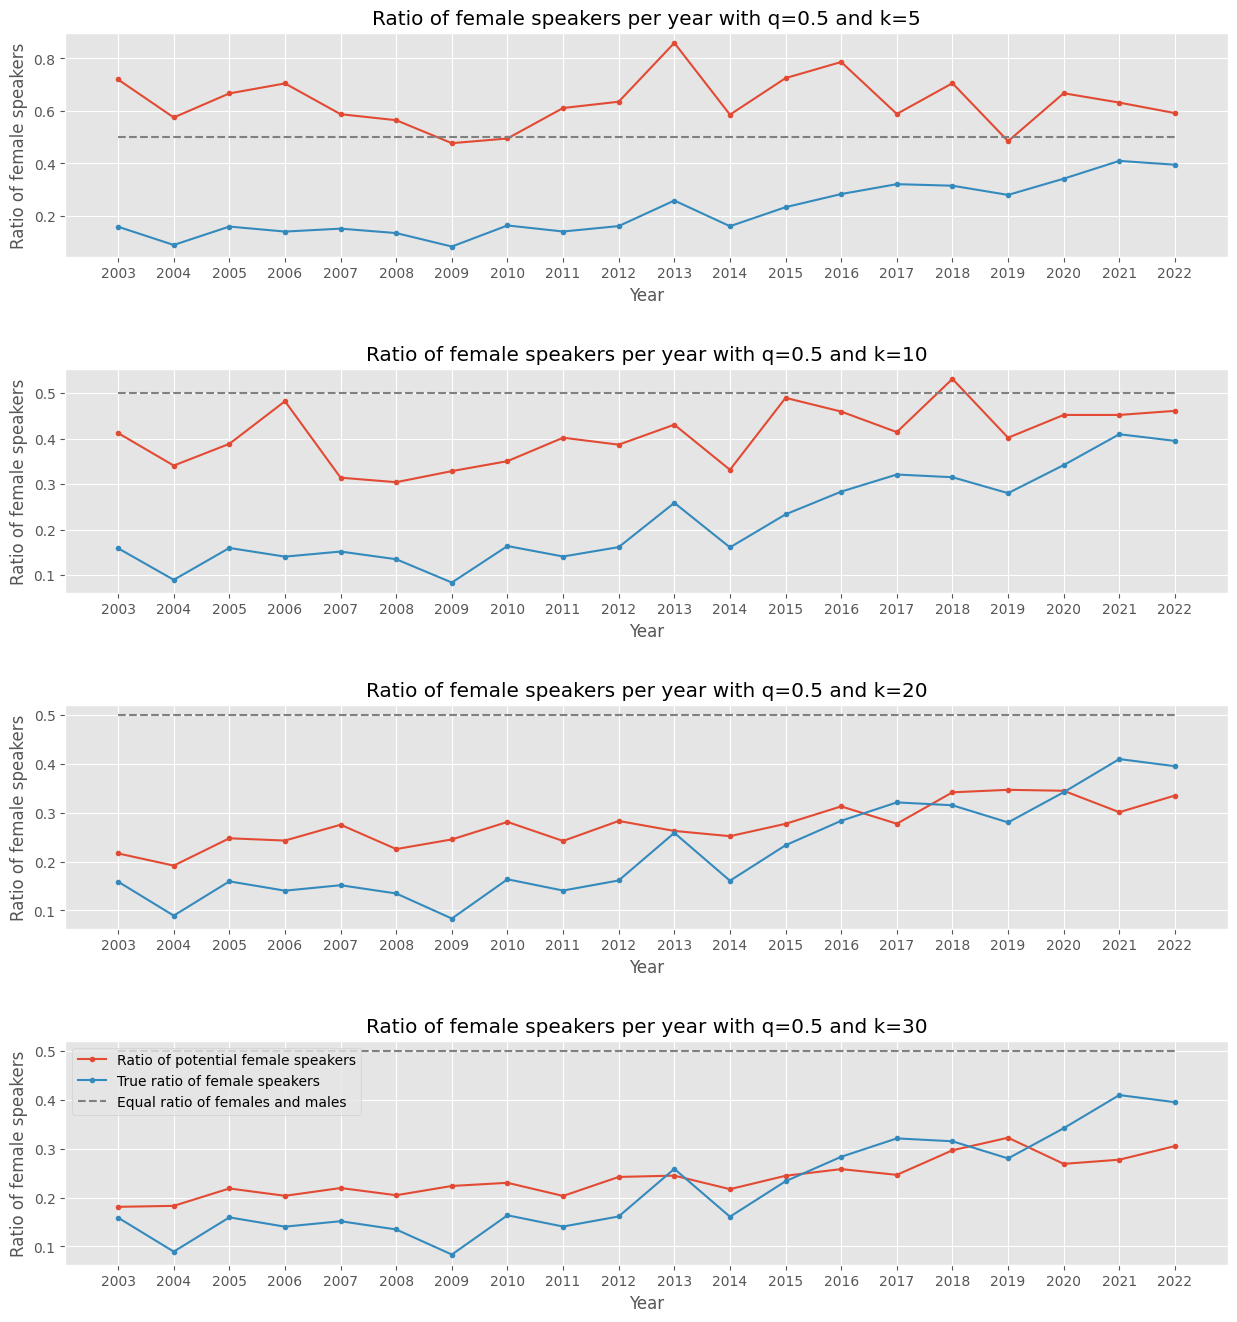

In [253]:
plt.figure(figsize=(15, 16))
plt.subplots_adjust(hspace=0.5)
k_list = [5,10,20,30]

for n, k in enumerate(k_list):
    ax = plt.subplot(len(k_list), 1, n + 1)
    
    _, total_list = knn_on_source(df,k=k,q=0.5)
        
    ax.plot(range(2003,2023),total_list,marker='.',label='Ratio of potential female speakers')
    # Plot the true ratio
    True_list = df_Invited.groupby('Year')['gender'].value_counts(normalize=True).unstack()['F'].values
    ax.plot(range(2003,2023),True_list,marker='.',label='True ratio of female speakers')

    ax.set_xticks(range(2003,2023,1))
    ax.set_xlabel('Year')
    ax.set_ylabel('Ratio of female speakers')
    ax.set_title('Ratio of female speakers per year with q='+str(0.5)+' and k=' + str(k))
    ax.hlines(0.5,2003,2022,linestyles='dashed',colors='grey', label='Equal ratio of females and males')

plt.legend()    
plt.show()

100%|██████████| 20/20 [00:03<00:00,  5.77it/s]


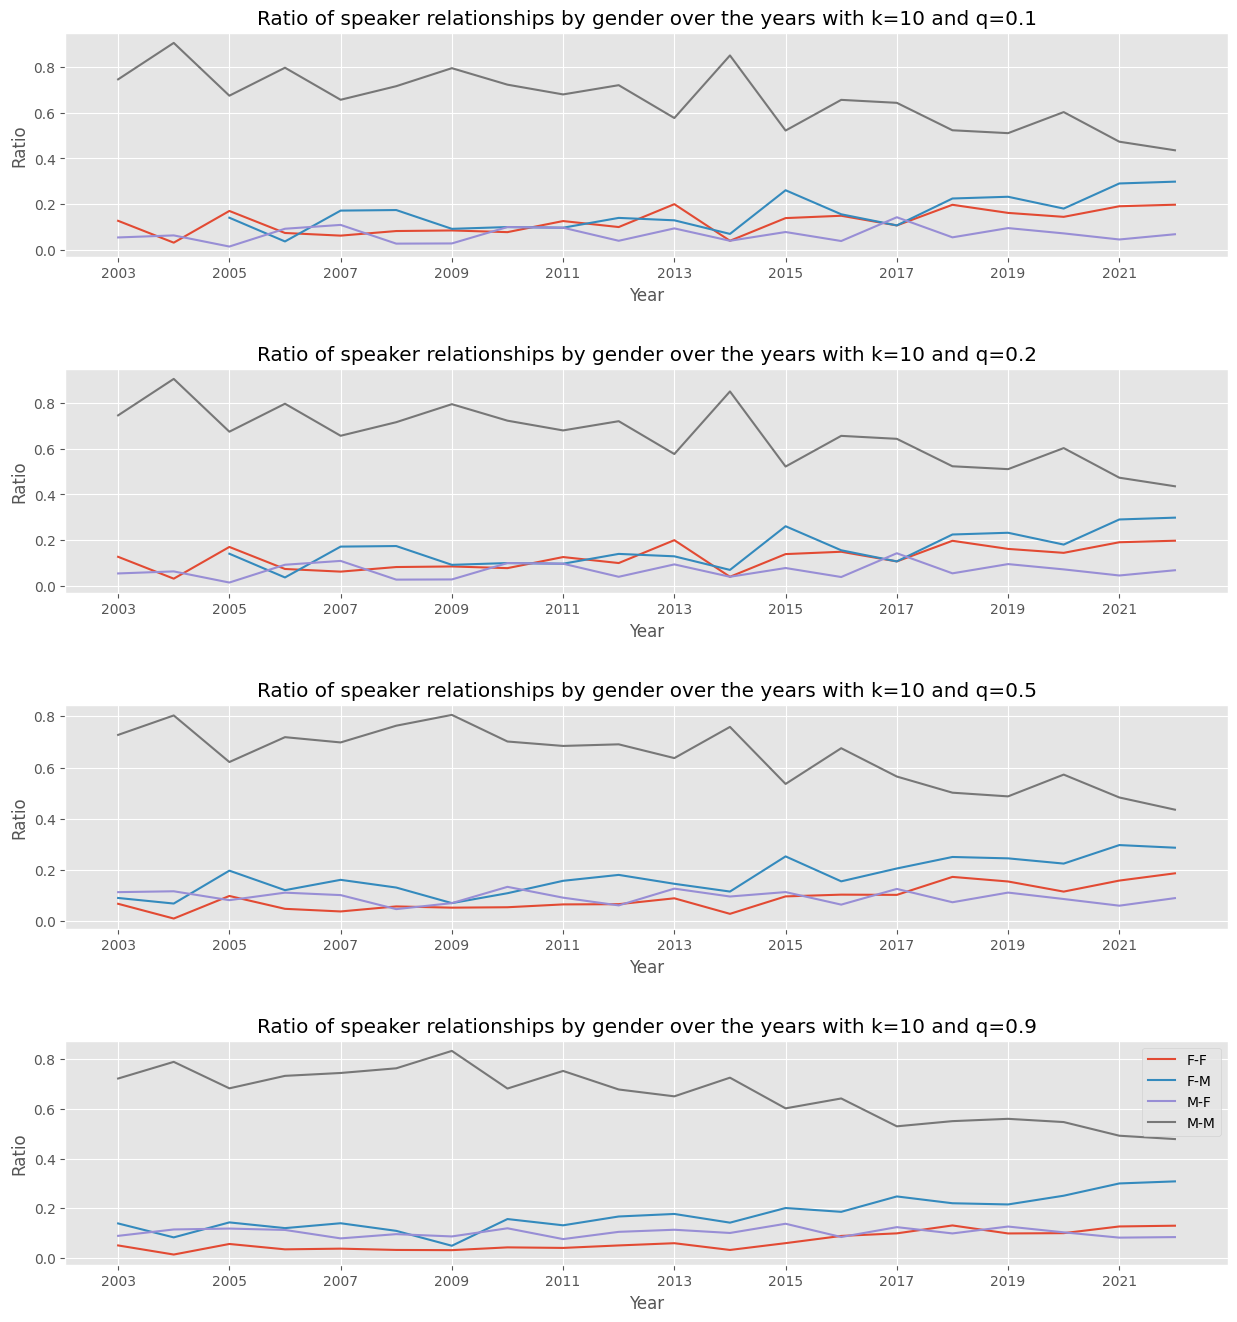

In [262]:
plt.figure(figsize=(15, 16))
plt.subplots_adjust(hspace=0.5)
q_list = [0.1,0.2,0.5,0.9]

for n, q in enumerate(q_list):
    ax = plt.subplot(len(q_list), 1, n + 1)
    
    df2, _ = knn_on_source(df,k=10,q=q)
        
    df2.groupby('Year')['Control'].value_counts(normalize=True).unstack().plot(kind='line',ax=ax,legend=False)
    ax.set_xticks(range(2003,2023,2))
    ax.set_xlabel('Year')
    ax.set_ylabel('Ratio')
    ax.set_title("Ratio of speaker relationships by gender over the years with k="+str(10)+" and q="+str(q))

plt.legend()
plt.show()

100%|██████████| 20/20 [00:05<00:00,  3.58it/s]


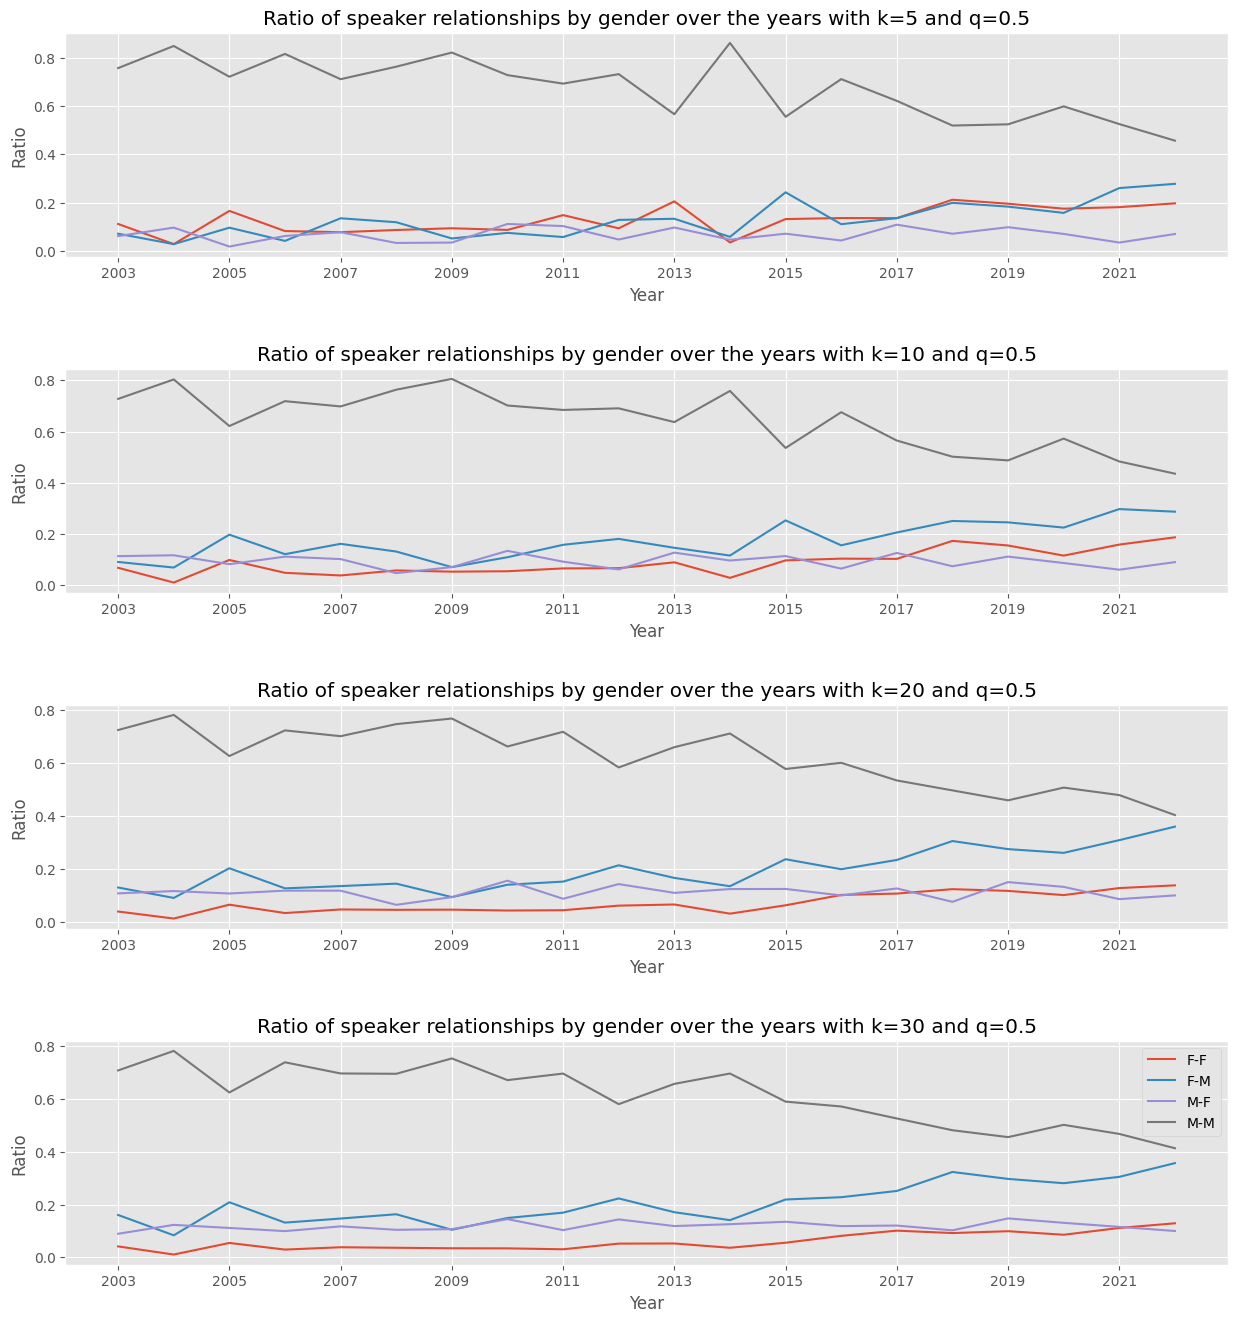

In [260]:
plt.figure(figsize=(15, 16))
plt.subplots_adjust(hspace=0.5)
k_list = [5,10,20,30]

for n, k in enumerate(k_list):
    ax = plt.subplot(len(k_list), 1, n + 1)
    
    df2, _ = knn_on_source(df,k=k,q=0.5)
        
    df2.groupby('Year')['Control'].value_counts(normalize=True).unstack().plot(kind='line',ax=ax,legend=False)
    ax.set_xticks(range(2003,2023,2))
    ax.set_xlabel('Year')
    ax.set_ylabel('Ratio')
    ax.set_title("Ratio of speaker relationships by gender over the years with k="+str(k)+" and q="+str(0.5))

plt.legend()
plt.show()

# Similarity Test

In [74]:
name_list = df[(df['Source'] == "Invited") & (df['gender'] == "M")]['Full name'].value_counts().head(10)
name_list

Tim Berners-Lee           9
Prabhakar Raghavan        7
Michael Kearns            4
David Haussler            4
Oren Etzioni              4
Yann LeCun                4
Josh Tenenbaum            4
Christos Papadimitriou    4
Jon Kleinberg             4
Martin Grohe              3
Name: Full name, dtype: int64

In [90]:
df_M.Year.unique()

array([2004, 2006, 2007, 2010, 2014, 2016, 2017, 2019, 2020, 2021, 2022,
       2009, 2012, 2013, 2018, 2003, 2005, 2011, 2008, 2015], dtype=int64)

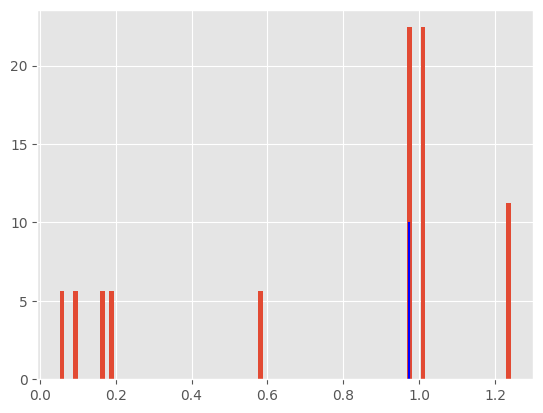

,Full name,Year,Conference (short),First name,Middle name,Last name,gender,column_equal,Paper Count,Max Paper Count,First year paper,ID,Age,Productivity,Conference (long),Main Topic,Source,log(Paper Count),idx,Age Group
179233,Yann LeCun,2012,ICML,Yann,NaN,LeCun,M,NaN,119,205,1988,NaN,24,4.958333,International Conference on Machine Learning,Artificial Intelligence,Invited,4.779123,179233,>20
179395,Michael Kearns,2012,KDD,Michael,NaN,Kearns,M,NaN,146,189,1987,NaN,25,5.840000,Conference on Knowledge Discovery and Data Mining,Data Management,Invited,4.983607,179395,>20
179678,Martin Grohe,2012,SODA,Martin,NaN,Grohe,M,NaN,127,209,1993,NaN,19,6.684211,Symposium on Discrete Algorithms,Algorithm and Theory,Invited,4.844187,179678,15-20
179731,Michael Kearns,2012,STOC,Michael,NaN,Kearns,M,NaN,146,189,1987,NaN,25,5.840000,Symposium on Theory of Computing,Algorithm and Theory,Invited,4.983607,179731,>20
179856,Tim Berners-Lee,2012,WWW,Tim,NaN,Berners-Lee,M,NaN,41,57,1988,NaN,24,1.708333,World Wide Web Conference,Data Management,Invited,3.713572,179856,>20


In [130]:
df1 = df[df['Year'] == 2012]
df_F = df1[df1['gender'] == 'F'].reset_index(drop=True)
df_M = df1[(df1['Full name'].isin(name_list.index)) & (df1['Source'] == "Invited")]

nbrs = NearestNeighbors(n_neighbors=3).fit(df_F[['log(Paper Count)','Productivity','Age']])
distances, indices = nbrs.kneighbors(df_M[['log(Paper Count)','Productivity','Age']])

# Find threshold
threshold = np.quantile(distances.flatten(),q=0.5)
plt.hist(distances.flatten(),bins=100,density=True)
plt.vlines(threshold,0,10,color = "blue")
plt.show()
mask = distances <= threshold

filtered_indices = indices.copy().astype(float)
filtered_indices[~mask] = np.nan
df_M

In [132]:
distances

array([[0.16991409, 1.00576097, 1.00838049],
       [0.97198886, 0.97198886, 1.24121336],
       [0.05321277, 0.58599305, 1.01156403],
       [0.97198886, 0.97198886, 1.24121336],
       [0.09598373, 0.19574385, 1.00382084]])

In [131]:
filtered_indices

array([[206.,  nan,  nan],
       [603., 941.,  nan],
       [551., 838.,  nan],
       [603., 941.,  nan],
       [301., 131.,  nan]])

In [142]:
df_F.loc[131]

Full name                                              Xing Chen
Year                                                        2012
Conference (short)                                          AAAI
First name                                                  Xing
Middle name                                                  NaN
Last name                                                   Chen
gender                                                         F
column_equal                                                True
Paper Count                                                   37
Max Paper Count                                              153
First year paper                                            1988
ID                                                   Xing Chen_1
Age                                                           24
Productivity                                            1.541667
Conference (long)     AAAI Conference on Artificial Intelligence
Main Topic               

In [ ]:
# Initiliaze ratio list
ratio_list = []

for i in range(0,n):
    results = df_M.copy()
    results['Similar idx'] = [random.choice(row) for row in indices.tolist()] # select index
    results = results.dropna(subset=['Similar idx'])
    results = results.merge(right = df_F, left_on='Similar idx', right_index=True, how='left',suffixes=['_M','_F']) # merge info
    
    try:
        P_males_inv = results['Source_M'].value_counts(normalize=True).loc['Invited']
        P_females_inv = results['Source_F'].value_counts(normalize=True).loc['Invited']
        ratio = np.divide(P_females_inv,P_males_inv)
        ratio_list.append(ratio)
    except:
        ratio_list.append(np.nan)
        continue

mean_ratio = np.nanmean(ratio_list)
std_ratio = np.nanstd(ratio_list)

return mean_ratio,std_ratio
# return ratio_list

# Similarity from F -> M M M

In [3]:
def Nearest_Neighbor(df,k,q,n):
    # Yes I am lazy, I know... 
    df_F = df[df['gender'] == 'M'].reset_index(drop=True)
    df_M = df[df['gender'] == 'F']

    nbrs = NearestNeighbors(n_neighbors=k).fit(df_F[['log(Paper Count)','Productivity','Age']])
    distances, indices = nbrs.kneighbors(df_M[['log(Paper Count)','Productivity','Age']])
    
    # Find threshold
    threshold = np.quantile(distances.flatten(),q=q)
    mask = distances <= threshold
    filtered_indices = indices.copy().astype(float)
    filtered_indices[~mask] = np.nan
    
    # Initiliaze ratio list
    ratio_list = []
    
    for i in range(0,n):
        results = df_M.copy()
        results['Similar idx'] = [random.choice(row) for row in indices.tolist()] # select index
        results = results.dropna(subset=['Similar idx'])
        results = results.merge(right = df_F, left_on='Similar idx', right_index=True, how='left',suffixes=['_M','_F']) # merge info
        
        try:
            P_males_inv = results['Source_M'].value_counts(normalize=True).loc['Invited']
            P_females_inv = results['Source_F'].value_counts(normalize=True).loc['Invited']
            ratio = np.divide(P_males_inv,P_females_inv) #females/males in reality
            ratio_list.append(ratio)
        except:
            ratio_list.append(np.nan)
            continue
    
    mean_ratio = np.nanmean(ratio_list)
    std_ratio = np.nanstd(ratio_list)
    
    return mean_ratio,std_ratio
    # return ratio_list

100%|██████████| 20/20 [00:08<00:00,  2.42it/s]


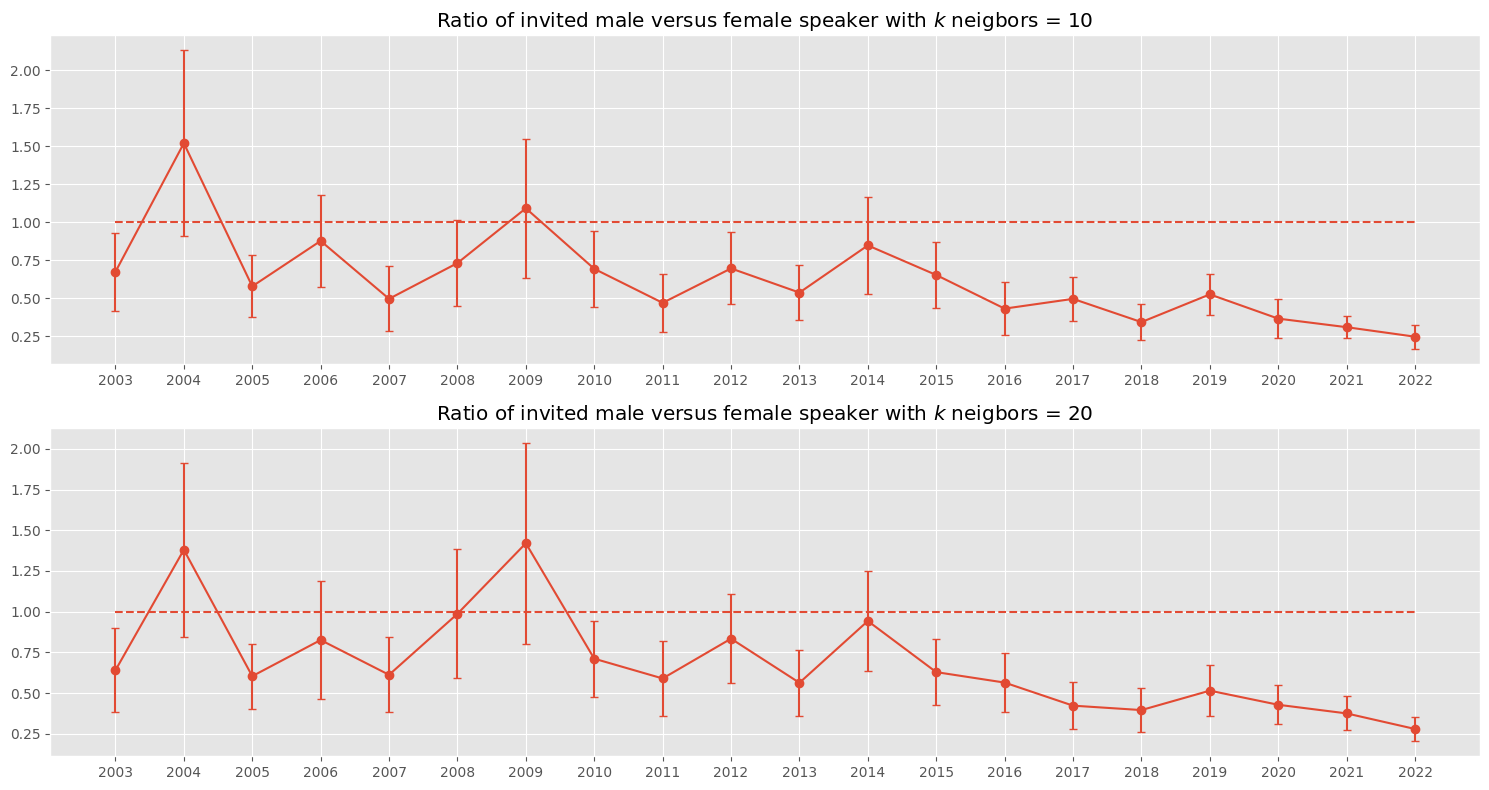

In [5]:
plt.figure(figsize=(15, 8))
plt.subplots_adjust(hspace=0.5)
k_list = [10,20]

for n, k in enumerate(k_list):
    ax = plt.subplot(len(k_list), 1, n + 1)
    # ax.plot(df['Age'],'o',alpha=0.1)
    
    ratio_list = []
    std_list = []
    for year in tqdm(range(2003,2023)):
        try:
            df_year = df[df['Year'] == year]
            mean_ratio, std_ratio = Nearest_Neighbor(df_year,k=k, q=0.5, n=50)
            ratio_list.append(mean_ratio)
            std_list.append(std_ratio)
        except: 
            ratio_list.append(np.NaN)
            std_list.append(np.NaN)
            continue
        
    ax.errorbar(range(2003,2023), ratio_list, yerr=std_list, fmt='o-', capsize=3,label="Adj. Ratio")
    ax.set_title('Ratio of invited male versus female speaker with $k$ neigbors = ' + str(k))
    ax.set_xticks(range(2003,2023,1))
    ax.hlines(1, 2003, 2022, linestyles='dashed')
    plt.tight_layout()